In [26]:
%%capture
!pip install statsforecast
!pip install mlforecast
!pip install utilsforecast
!pip install tsfeatures
!pip install squarify
!pip install neuralforecast
!pip install utilsforecast

!pip install neuralforecast datasetsforecast

In [ ]:
%%capture
#needed to fix torch version issues
!pip uninstall -y torch torchvision
!pip install torch torchvision

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from prophet import Prophet
import os


import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    DIR = '/content/drive/MyDrive/AIM/Timeseries/FinalProject'
else:
    DIR = '.'

plt.style.use("ggplot")

plt.rcParams.update({
    "figure.figsize": (10, 4),
    "figure.dpi": 100,
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
})

pd.set_option("display.precision", 3)
np.set_printoptions(suppress=True)

In [ ]:
### Consolidate Import and Export data
DAT_Export = pd.read_csv(f'{DIR}/data/SPGlobal_Exports_clean.csv',
                         parse_dates=['ds'])
DAT_Export.dropna(axis=0, inplace=True)
DAT_Export.columns = [f'{x}_export' if x != 'ds' else x for x in DAT_Export.columns]
DAT_Export = DAT_Export.melt(id_vars=['ds'], var_name='unique_id', value_name='y', ignore_index=True)


DAT_Import = pd.read_csv(f'{DIR}/data/SPGlobal_Imports_clean.csv', parse_dates=['ds'])
DAT_Import.dropna(axis=0, inplace=True)
DAT_Import.columns = [f'{x}_import' if x != 'ds' else x for x in DAT_Import.columns]
DAT_Import = DAT_Import.melt(id_vars=['ds'], var_name='unique_id', value_name='y', ignore_index=True)

DAT = pd.concat([DAT_Export, DAT_Import], axis=0)
DAT[DAT.ds > '2023-12-01'].reset_index(drop=True).to_csv(f'{DIR}/TEST.csv')
DAT[DAT.ds <= '2023-12-01'].reset_index(drop=True).to_csv(f'{DIR}/TRAIN.csv')

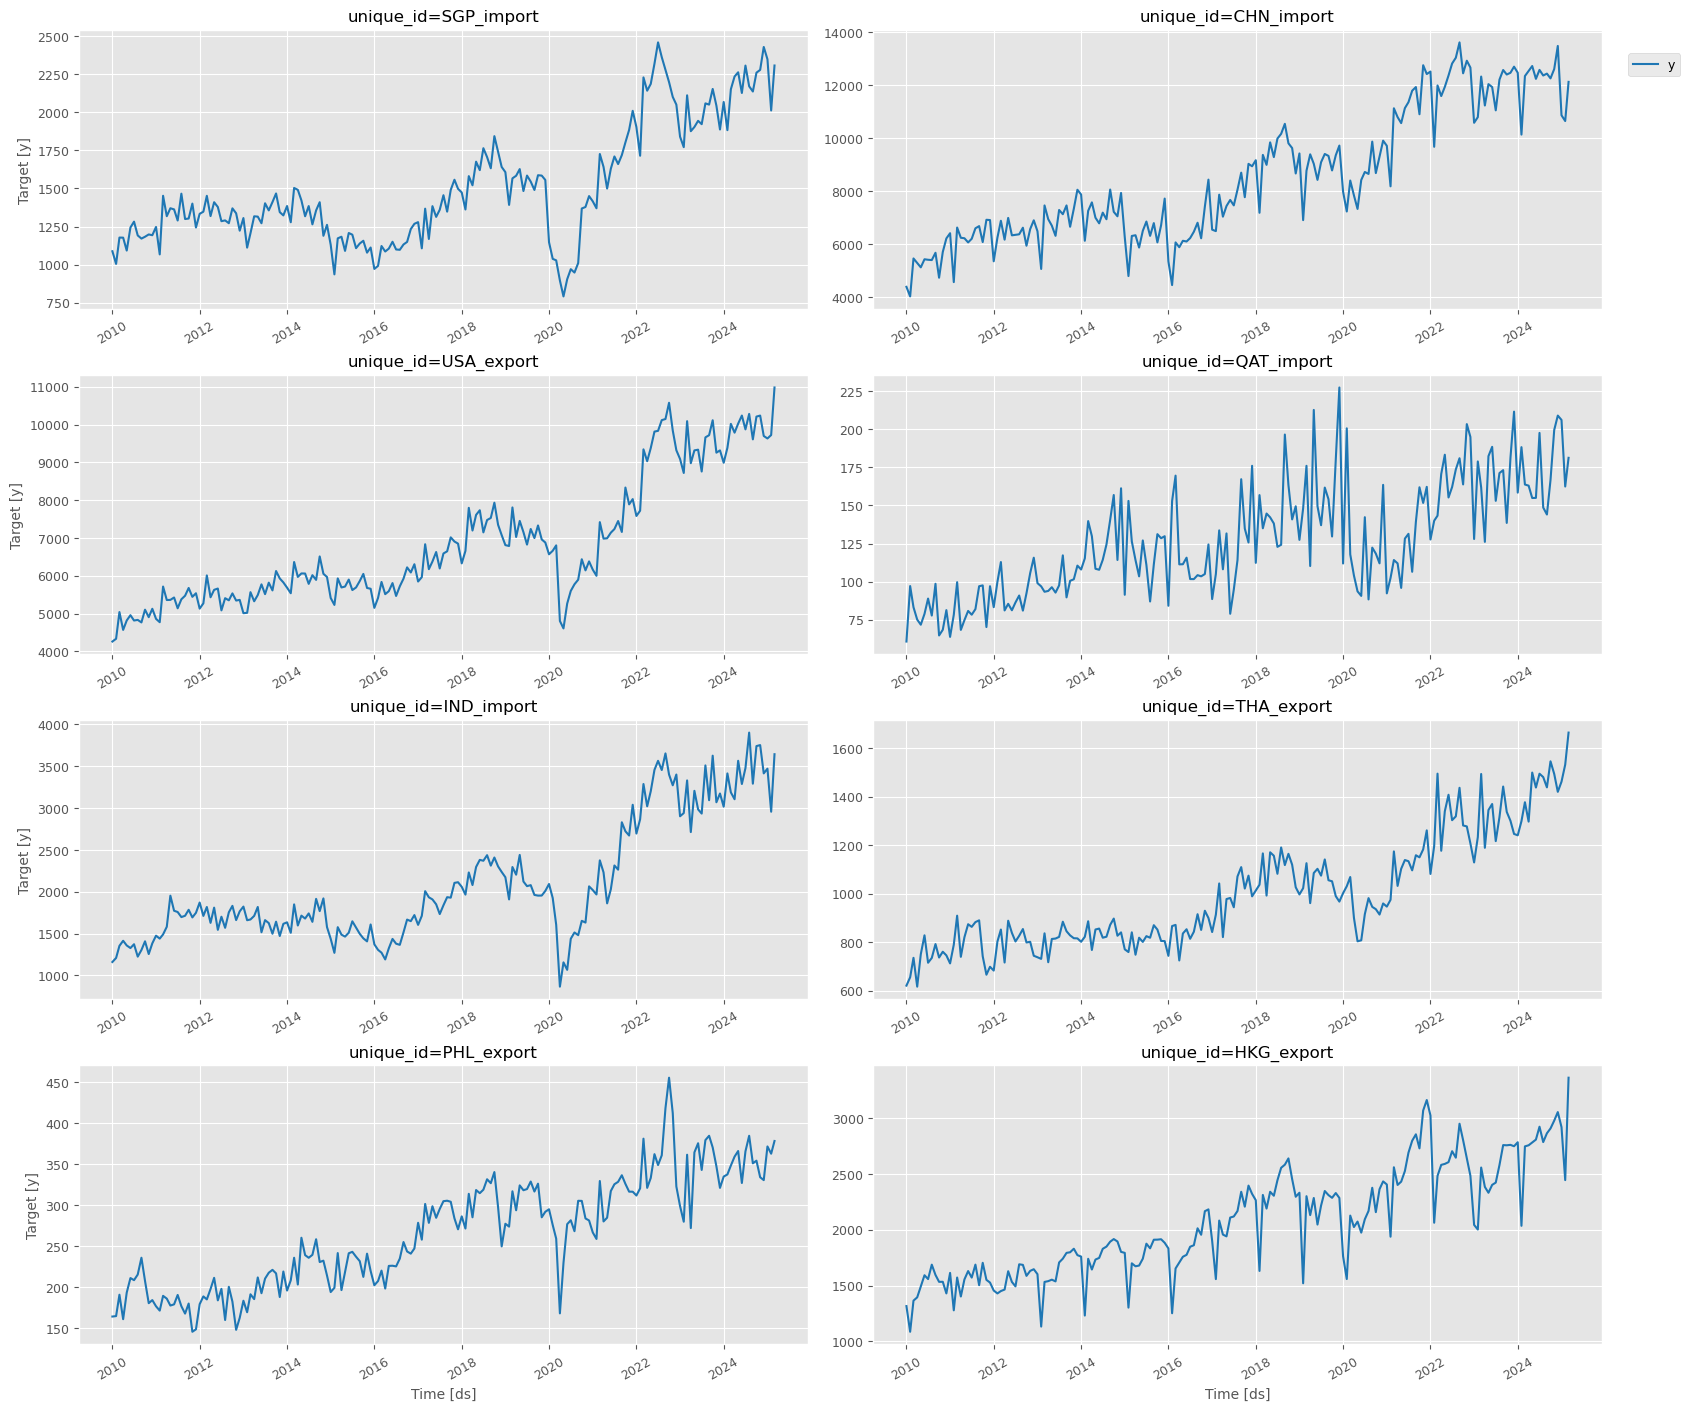

In [ ]:
DAT_TRAIN = pd.read_csv(f'{DIR}/TRAIN.csv', parse_dates=['ds'],index_col=0)
DAT_TEST = pd.read_csv(f'{DIR}/TEST.csv', parse_dates=['ds'],index_col=0)


from utilsforecast.plotting import plot_series

custom_colors = ["black", "tab:blue"]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)
plot_series(DAT_TRAIN,
            DAT_TEST)


### Model A: Baseline DeepAR (Vanilla model)
Here we test the vanilla Deep Learning models such as DeepAR, NBeats, and TSMixer. These models are available under NIXTLA's Neuralforecast package.

We investigate whether a global ML model can forecast the import and export activity. In particular, we assess whether a global model, with cross-learning, can out-perform local models trained for specific dataset.

Model A is a vanilla model of DeepAR using the import and export volumes as inputs (without introducing any engineered features)

In [30]:
from neuralforecast import NeuralForecast
from neuralforecast.models import DeepAR #TFT, NBEATS, TimeGPT
from neuralforecast.losses.pytorch import DistributionLoss
import torch
torch.set_float32_matmul_precision('medium')


h = len(DAT_TEST.ds.unique())

models = [DeepAR(h=h,
                 input_size=2*h, #when predicting h, lookback 2*h
                 max_steps=2000,
                 scaler_type='robust',
                 trajectory_samples=200,
                 loss=DistributionLoss(distribution='StudentT', level=[80, 95]),
                 lstm_n_layers=2, #By default this is 1
                 lstm_hidden_size=64,
                 decoder_hidden_layers=2, #MLP layers, we force it. Be default = 0, linear layer
                 decoder_hidden_size=64, 
                 ),
          ]

nf = NeuralForecast(models=models, freq='M')
nf.fit(df=DAT_TRAIN)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x110f4e690>>
Traceback (most recent call last):
  File "/Users/mlgcastanares/opt/anaconda3/envs/BankSentiment/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | DistributionLoss | 5      | train
1 | valid_loss   | MAE              | 0      | train
2 | padder_train | ConstantPad1d    | 0      | train
3 | scaler       | TemporalNorm     | 0      | train
4 | hist_encoder | LSTM             | 50.4 K | train
5 | decoder      | Decoder          | 4.4 K  | train
--------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


AttributeError: 'tuple' object has no attribute 'tb_frame'

In [ ]:
from functools import partial
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import rmse, mae, mape as _mape, mase, rmsse

df_f = nf.predict() # Forecast!

def mape(df, models, id_col="unique_id", target_col="y"):
    df_mape = _mape(df, models, id_col=id_col, target_col=target_col)
    df_mape.loc[:, df_mape.select_dtypes(include='number').columns] *= 100
    return df_mape

df_f = pd.merge(DAT_TEST, df_f, on=['ds', 'unique_id']) # append ground truth "y"

df_eval = evaluate(df_f, 
                   metrics=[mae, rmse, mape, partial(mase, seasonality=12),
                                   partial(rmsse, seasonality=12)],
                   train_df=DAT_TRAIN) # mase uses snaive as scaler
df_eval.pivot(index='unique_id', columns='metric', values='DeepAR')

In [ ]:
from utilsforecast.plotting import plot_series

custom_colors = ["black", "tab:blue"]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)
plot_series(DAT_TEST, df_f.drop(['DeepAR-median', 'y'], axis=1), level=[80, 95])

### Model B: DeepAR with feature engineering
Now we add some context to the forecast by adding static covariates. This would capture country-specific and time-specific trends.



In [32]:
### (b) features DeepAR
from functools import partial
from utilsforecast.feature_engineering import fourier, time_features, pipeline

features = [
    partial(fourier, season_length = 3, k=2),
    partial(time_features, features = ['quarter'])
]

df_train, df_futr = pipeline(
    DAT_TRAIN,
    features = features,
    freq = 'MS',
    h=h
)

df_train


### (c) STL + DeepAR


### (d) STL + features

,ds,unique_id,y,sin1_3,sin2_3,cos1_3,cos2_3,quarter
0,2010-01-01,AUS_export,618.538,8.660e-01,-8.660e-01,-0.5,-0.5,1
1,2010-02-01,AUS_export,613.971,-8.660e-01,8.660e-01,-0.5,-0.5,1
2,2010-03-01,AUS_export,699.770,1.748e-07,3.497e-07,1.0,1.0,1
3,2010-04-01,AUS_export,769.386,8.660e-01,-8.660e-01,-0.5,-0.5,2
4,2010-05-01,AUS_export,829.484,-8.660e-01,8.660e-01,-0.5,-0.5,2
...,...,...,...,...,...,...,...,...
6043,2023-08-01,VNM_import,1606.879,-8.660e-01,8.660e-01,-0.5,-0.5,3
6044,2023-09-01,VNM_import,1619.624,3.418e-06,6.835e-06,1.0,1.0,3
6045,2023-10-01,VNM_import,1621.277,8.660e-01,-8.660e-01,-0.5,-0.5,4
6046,2023-11-01,VNM_import,1619.630,-8.660e-01,8.660e-01,-0.5,-0.5,4
